In [1]:
import numpy as np
import pandas as pd
from scipy.stats import spearmanr, pearsonr
from os.path import expanduser
from sklearn import mixture
import itertools
from scipy import linalg
import matplotlib as mpl
mpl.use('agg')
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
from pprint import pprint
from factslab.utility.lcsreader import LexicalConceptualStructureLexicon
from factslab.utility import ridit, r1_score, dev_mode_group

home = expanduser('~')
%matplotlib inline
pd.set_option('mode.chained_assignment', None)
pd.set_option('display.max_colwidth', -1)

# Load the data

In [2]:
attributes_pred = ['Is.Particular.Norm', 'Is.Hypothetical.Norm', 'Is.Dynamic.Norm']
pred_datafile = home + "/Research/protocols/data/pred_raw_data_norm_012919.tsv"
pred_data = pd.read_csv(pred_datafile, sep="\t")
pred_data = pred_data[pred_data['Split'].isin(['train', 'dev'])]
pred_data_unq = pred_data.groupby('Unique.ID', as_index=False).apply(lambda x: dev_mode_group(x, attributes_pred, type="regression")).reset_index(drop=True)
print("Predicate train + dev data unique shape", pred_data_unq.shape)

attributes_arg = ['Is.Particular.Norm', 'Is.Kind.Norm', 'Is.Abstract.Norm']
arg_datafile = home + "/Research/protocols/data/noun_raw_data_norm_012919.tsv"
arg_data = pd.read_csv(arg_datafile, sep="\t")
arg_data = arg_data[arg_data['Split'].isin(['train', 'dev'])]
arg_data_unq = arg_data.groupby('Unique.ID', as_index=False).apply(lambda x: dev_mode_group(x, attributes_arg, type="regression")).reset_index(drop=True)
print("Argument train + dev data unique shape", arg_data_unq.shape)

Predicate train + dev data unique shape (29994, 26)
Argument train + dev data unique shape (33646, 25)


# Concreteness correlations

In [5]:
conc_data = arg_data_unq.copy()

path = home + "/Research/protocols/data/concreteness.tsv"
conc = pd.read_csv(path, sep="\t")
list_of_lemmas = conc['Word'].values.tolist()

abs_conc = conc_data.groupby('Arg.Lemma')['Is.Abstract.Norm'].mean().to_frame().reset_index()
abs_conc['conc'] = abs_conc['Arg.Lemma'].map(lambda x: (conc[conc['Word'] == x.lower()]['Conc.M']).values[0] if x.lower() in list_of_lemmas else -1)

ini = len(abs_conc)
abs_conc = abs_conc[abs_conc['conc'] != -1]
print("Percentage of lemmas found in database:", len(abs_conc) / ini)
print("Spearman correlation: ", np.round(spearmanr(abs_conc['Is.Abstract.Norm'].values, abs_conc['conc'].values)[0], 2))
print("Pearson correlation: ", np.round(pearsonr(abs_conc['Is.Abstract.Norm'].values, abs_conc['conc'].values)[0], 2))

Percentage of lemmas found in database: 0.6633102580239144
Spearman correlation:  -0.45
Pearson correlation:  -0.44


# LCS

In [6]:
path = home + "/Research/protocols/data/verbs-English.lcs"
lcs = LexicalConceptualStructureLexicon(path)

lcs_data = pred_data_unq.copy()

dyn_lcs = lcs_data.groupby('Pred.Lemma')['Is.Dynamic.Norm'].apply(list).to_frame().reset_index()
dyn_lcs['lcs'] = dyn_lcs['Pred.Lemma'].map(lambda x: lcs.eventive(x.lower()) if x.lower() in lcs.verbs else -1)
num_of_lemmas = len(dyn_lcs)
dyn_lcs = dyn_lcs[dyn_lcs['lcs'] != -1]
dyn_lcs.set_index('Pred.Lemma', inplace=True)
dyn_lcs['dyn'] = dyn_lcs['Is.Dynamic.Norm'].apply(lambda x: [a > 0 for a in x])
dyn_lcs['comp'] = dyn_lcs.apply(lambda x: 1 if set(x['dyn']).intersection(set(x['lcs'])) else 0, axis=1)

print("Percentage of lemmas found in lcs database:", len(dyn_lcs) / num_of_lemmas)
print("They share at least one sense:", sum(dyn_lcs['comp']) / len(dyn_lcs))

Percentage of lemmas found in lcs database: 0.43727794479365945
They share at least one sense: 0.864375


In [7]:
dyn_lcs['comp'] = dyn_lcs.apply(lambda x: 1 if set(x['dyn']).issubset(set(x['lcs'])) else 0, axis=1)

print("Percentage of lemmas found in lcs database:", len(dyn_lcs) / num_of_lemmas)
print("They share at least one sense:", sum(dyn_lcs['comp']) / len(dyn_lcs))

Percentage of lemmas found in lcs database: 0.43727794479365945
They share at least one sense: 0.409375


In [8]:
from sklearn.metrics import matthews_corrcoef

dyn_lcs['lcs_event'] = dyn_lcs['lcs'].map(lambda x: True in x)
dyn_lcs['udsg_event'] = dyn_lcs['dyn'].map(lambda x: True in x)

dyn_lcs['lcs_state'] = dyn_lcs['lcs'].map(lambda x: False in x)
dyn_lcs['udsg_state'] = dyn_lcs['dyn'].map(lambda x: False in x)

(dyn_lcs['lcs_event']==dyn_lcs['udsg_event']).sum()/num_of_lemmas, (dyn_lcs['lcs_state']==dyn_lcs['udsg_state']).sum()/num_of_lemmas


(0.3566548237223285, 0.18283684066684885)

In [11]:
pd.set_option('display.max_rows', 100000)
display(dyn_lcs[(dyn_lcs['lcs_event']==True) & (dyn_lcs['udsg_event']==True) & (dyn_lcs['lcs_state']==True) & (dyn_lcs['udsg_state']==True)])

,Is.Dynamic.Norm,lcs,dyn,comp,lcs_event,udsg_event,lcs_state,udsg_state
Pred.Lemma,,,,,,,,
accept,"[0.20296302663944, 0.2994303298229392, 0.5694433860620092, 1.5767919050395007, 0.96911643818119, 1.0222605031756018, 0.2552787071753104, 1.177442458413959, -0.4921388308985682, 0.5625588825715327, -0.11544745531592135, -0.5909448250152747, 0.823250729308583, 0.9235293418309388, -1.0814872900713544, 0.7966663025766214, 1.5792635611744494, 0.5687032678746538, 1.7620811498024307, -1.7836398630571226, 1.2668575145431653, 1.1822811776742526, 1.0992179727187308, 1.2002015283876215, 1.0797285419317866, 1.2838093244923448, 1.499873366270278, -0.7884369849739816, -0.5639585640245235]","[True, False, False, True]","[True, True, True, True, True, True, True, True, False, True, False, False, True, True, False, True, True, True, True, False, True, True, True, True, True, True, True, False, False]",1,True,True,True,True
acknowledge,"[0.6215829920578091, 0.8699579921139884, -0.2803429369116158, 0.5551763789990931, 0.7114679820925045]","[False, False, False, True, True]","[True, True, False, True, True]",1,True,True,True,True
admit,"[0.33478497597245216, 0.5994740480471595, 2.137072528999702, -0.8263829558670812, 0.6220389534877623, -0.32414902606776463, -0.03242172255604092, 0.7445197606921948, 1.2275399609399338, 1.1610122604325763, 1.20630706545096, 2.209534775233619, -1.9682353401430308, 0.08573213503695147, 1.9228190750242768, 0.40200434710289396, -0.27060945733105457]","[False, True, True]","[True, True, True, False, True, False, False, True, True, True, True, True, False, True, True, True, False]",1,True,True,True,True
adopt,"[-1.3708665871315888, 0.5598964083361961, 0.8481996342780539, 0.5452501749967856, 0.8239485511741659, 1.0408979548625863]","[False, True, True, True]","[False, True, True, True, True, True]",1,True,True,True,True
allow,"[-0.2041180307320288, -0.48374059710738243, 0.6076255821277897, 0.04851366735978252, 0.7266378868561528, 0.52595032726362, 0.5656064181642476, 0.24873569197283416, 0.9734420117896614, -0.7400413305215876, -0.8093438385838215, 1.6325216267681688, 0.38322849968879, 0.32672998376728857, -0.5332023769005239, -0.6005217066580681, 0.6578469041958648, 0.7712407367293773, -0.3373944733553553, -0.8457403843570842, -0.18716185730375184, -0.5660476266811885, 1.1882468279841203, 1.1027448519801917, -0.9679915202437168, 0.5006412908054944, -0.3558794535433314, 0.02300039070614936, 1.4854143115047052, -1.1212212730561888, -0.4907024847532403, 0.8748917521854036, 0.3829641996663664, 0.5661356340255267, 0.5288830560074949, 0.5823913013938616]","[False, True, True]","[False, False, True, True, True, True, True, True, True, False, False, True, True, True, False, False, True, True, False, False, False, False, True, True, False, True, False, True, True, False, False, True, True, True, True, True]",1,True,True,True,True
appear,"[0.22920380758216305, -1.6837121876778134, 0.3974571231921901, -0.5362876344822051, 0.5119859532078952, 1.3283645715131012, -0.2285344945283096, 0.11534415658382755, -1.2199524540807891, 0.492181822079271, 0.11015331278015712, -0.4914892404777042, -0.6048851058016966, 0.09367074033561393, 0.6319232118825466, 1.038592411797138, -0.8808114400107708, -0.4468329709106744, 0.2206750945670391, -0.10266278628466548, 0.4258589460263748, -0.8525225432586122]","[True, False, True]","[True, False, True, False, True, True, False, True, False, True, True, False, False, True, True, True, False, False, True, False, True, False]",1,True,True,True,True
appreciate,"[0.6382203882410553, -0.3821254594613477, -0.3261266069936001, 0.5238665512310784, -0.1861982184485738, 0.5371203907948231, -0.34045403019093345, 0.8176087635554156, 1.251487763562686, -0.7286708658734181, 0.720091307016446, 0.4994553296832077, 1.640369576123349, -0.7859497192775268, -0.29938238961199504, 0.8120035465354275, 1.630102782468598, -1.062980000360466, -0.3137642048429557, -3.744644156975944, 0.09559459992583648, -2.2719387740880315, 1.84037059

# Factuality

In [18]:
datafile_ = home + "/Research/protocols/data/it-happened_eng_ud1.2_07092017_normalized.tsv"
fact_data = pd.read_csv(datafile_, sep="\t")

pred_data_f = pred_data_unq.copy()
pred_data_f['Sentence.ID'] = pred_data_f['Sentence.ID'].str.replace('sent_', '', regex=False)
pred_data_f['Unique.ID'] = pred_data_f.apply(lambda x: str(x['Sentence.ID']) + "_" + str(x["Pred.Token"]), axis=1)
pred_data_f = pred_data_f.groupby('Unique.ID', as_index=False).apply(lambda x: dev_mode_group(x, attributes_pred, type="regression")).reset_index(drop=True)

fact_data = fact_data[fact_data['Split'].isin(['train', 'dev'])]
fact_data['Unique.ID'] = fact_data.apply(lambda x: str(x['Sentence.ID']) + "_" + str(x["Pred.Token"]), axis=1)
fact_data = fact_data.groupby('Unique.ID', as_index=False).mean().reset_index(drop=True)

hyp_fact = pred_data_f.loc[:, ['Unique.ID', 'Is.Hypothetical.Norm', 'Is.Particular.Norm', 'Is.Dynamic.Norm']]
fact_ids = fact_data['Unique.ID'].tolist()
hyp_fact['Happened.Norm'] = hyp_fact['Unique.ID'].apply(lambda x: fact_data[fact_data['Unique.ID'] == x]['Happened.Norm'].iloc[0] if x in fact_ids else None)
hyp_fact2 = hyp_fact.dropna()
print("Overlap percentage", np.round(len(hyp_fact2) / len(hyp_fact), 2))
# asdf = hyp_fact2[(hyp_fact2['Is.Hypothetical.Norm']>1) & (hyp_fact2['Happened.Norm']<-1)]
for attr in ['Is.Hypothetical.Norm', 'Is.Particular.Norm', 'Is.Dynamic.Norm']:
    print(attr)
    print("Spearman correlation: ", np.round(spearmanr(hyp_fact2[attr].values, hyp_fact2['Happened.Norm'].values)[0], 2))
    print("Pearson correlation: ", np.round(pearsonr(hyp_fact2[attr].values, hyp_fact2['Happened.Norm'].values)[0], 2))

Overlap percentage 0.78
Is.Hypothetical.Norm
Spearman correlation:  -0.25
Pearson correlation:  -0.25
Is.Particular.Norm
Spearman correlation:  0.12
Pearson correlation:  0.11
Is.Dynamic.Norm
Spearman correlation:  0.02
Pearson correlation:  0.02


# Plot Bars

In [ ]:
x = ['Token', 'Type', 'GloVe', 'ELMO', 'Hand', 'All']
ind = np.arange(len(x))
y_part = [39.2, 51.6, 44.8, 58.2, 54.8, 58.0]
y_kind = [26.0, 42.0, 33.1, 47.9, 45.6, 48.0]
y_abs = [49.2, 34.4, 46.9, 55.8, 51.6, 56.2]

plt.figure()
plt.suptitle('Argument correlation scores')
ax = plt.subplot(111)
# ax.set_xlabel('Model features')
ax.set_ylabel('Pearson correlation')
ax.bar(ind - 0.2, y_part, width=0.2, color='b', align='center', label='Particular')
ax.bar(x, y_kind, width=0.2, color='g', align='center', label='Kind')
ax.bar(ind + 0.2, y_abs, width=0.2, color='r', align='center', label='Abstract')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
# plt.savefig('bars-arg-pear.png')


x = ['Token', 'Type', 'GloVe', 'ELMO', 'Hand', 'All']
ind = np.arange(len(x))
y_part = [16.3, 20.9, 20.3, 27.5, 24.7, 28.5]
y_hyp = [13.8, 38.3, 22.9, 42.2, 38.8, 42.0]
y_dyn = [33.2, 31.5, 29.4, 38.3, 37.5, 38.8]

plt.figure()
plt.suptitle('Predicate correlation scores')
ax = plt.subplot(111)
# ax.set_xlabel('Model features')
ax.set_ylabel('Pearson correlation')
ax.bar(ind - 0.2, y_part, width=0.2, color='b', align='center', label='Particular')
ax.bar(x, y_hyp, width=0.2, color='g', align='center', label='Hypothetical')
ax.bar(ind + 0.2, y_dyn, width=0.2, color='r', align='center', label='Dynamic')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
# plt.savefig('bars-pred-pear.png')


x = ['Token', 'Type', 'GloVe', 'ELMO', 'Hand', 'All']
ind = np.arange(len(x))
y_part = [7.9, 13.1, 9.7, 15.7, 13.5, 15.8]
y_kind = [2.1, 8.9, 2.6, 11.6, 10.8, 11.4]
y_abs = [14.1, 6.3, 11.9, 17.3, 15.2, 17.7]

plt.figure()
plt.suptitle('Argument R1 scores')
ax = plt.subplot(111)
ax.set_xlabel('Model features')
ax.set_ylabel('R1')
ax.bar(ind - 0.2, y_part, width=0.2, color='b', align='center', label='Particular')
ax.bar(x, y_kind, width=0.2, color='g', align='center', label='Kind')
ax.bar(ind + 0.2, y_abs, width=0.2, color='r', align='center', label='Abstract')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
# plt.savefig('bars-arg-r1.png')


x = ['Token', 'Type', 'GloVe', 'ELMO', 'Hand', 'All']
ind = np.arange(len(x))
y_part = [1.2, 2.7, 2.2, 3.9, 3.4, 4.5]
y_hyp = [0, 3.7, 0, 6.0, 2.9, 7.2]
y_dyn = [6.0, 5.4, 4.6, 7.8, 7.9, 8.4]

plt.figure()
plt.suptitle('Predicate R1 scores')
ax = plt.subplot(111)
# ax.set_xlabel('Model features')
ax.set_ylabel('R1')
ax.bar(ind - 0.2, y_part, width=0.2, color='b', align='center', label='Particular')
ax.bar(x, y_hyp, width=0.2, color='g', align='center', label='Hypothetical')
ax.bar(ind + 0.2, y_dyn, width=0.2, color='r', align='center', label='Dynamic')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
# plt.savefig('bars-pred-r1.png')

# SPR

In [27]:
arg_data_spr = arg_data_unq.copy()
arg_data_spr['Sentence.ID'] = arg_data_spr['Sentence.ID'].str.replace('sent_', '', regex=False)
arg_data_spr['Unique.ID'] = arg_data_spr.apply(lambda x: str(x['Sentence.ID']) + "_" + str(x['Arg.Span']).split(',')[0] + "_" + str(x['Arg.Span']).split(',')[-1], axis=1)
arg_data_spr = arg_data_spr.dropna()
arg_data_spr = arg_data_spr.groupby('Unique.ID', as_index=True).mean()

datafile_ = home + "/Research/protocols/data/spr/protoroles_eng_ud1.2_11082016.tsv"
spr = pd.read_csv(datafile_, sep="\t")
# pred_data token is 0 indexed in SPR
spr['Unique.ID'] = spr.apply(lambda x: str(x['Sentence.ID']) + "_" + str(x["Arg.Tokens.Begin"] + 1) + "_" + str(x["Arg.Tokens.End"] + 1), axis=1)
spr = spr[~spr['Is.Pilot']]
spr = spr.dropna()

spr = spr[spr['Split'].isin(['train', 'dev'])]

properties = ['awareness', 'volition', 'sentient', 'instigation', 'existed_before', 'existed_during', 'existed_after', 'was_for_benefit', 'change_of_location', 'change_of_state', 'was_used', 'change_of_possession', 'partitive']

print("Arg\n")
for prop in properties:
    prop_df = spr[spr['Property'] == prop]
    prop_df.loc[:, 'Response.ridit'] = prop_df.groupby('Annotator.ID')['Response'].transform(ridit)
    prop_df = prop_df.groupby('Unique.ID', as_index=False).mean().reset_index(drop=True)
    prop_df = prop_df.loc[:, ['Unique.ID', 'Response.ridit']].dropna()

    for attr in attributes_arg:
        prop_df.loc[:, attr] = prop_df['Unique.ID'].apply(lambda x: arg_data_spr.loc[x][attr] if x in arg_data_spr.index else None)
#     print(prop_df.shape)
    prop_df = prop_df.dropna()
#     print(prop_df.shape)
    print(prop.replace('_', ' '), 
          '&', np.round(spearmanr(prop_df[attributes_arg[0]].values, prop_df['Response.ridit'].values)[0], 2), 
          '&', np.round(spearmanr(prop_df[attributes_arg[1]].values, prop_df['Response.ridit'].values)[0], 2), 
          '&', np.round(spearmanr(prop_df[attributes_arg[2]].values, prop_df['Response.ridit'].values)[0], 2), "\\\\")

pred_data_spr = pred_data_unq.copy()
pred_data_spr['Sentence.ID'] = pred_data['Sentence.ID'].str.replace('sent_', '', regex=False)

lst_col = 'Arg.Span'
x = pred_data_spr.assign(**{lst_col: pred_data_spr[lst_col].str.split(';')})
pred_data_spr = pd.DataFrame({col: np.repeat(x[col].values, x[lst_col].str.len()) for col in x.columns.difference([lst_col])}).assign(**{lst_col: np.concatenate(x[lst_col].values)})[x.columns.tolist()]
pred_data_spr['Unique.ID'] = pred_data_spr.apply(lambda x: str(x['Sentence.ID']) + "_" + str(x['Arg.Span']).split(',')[0] + "_" + str(x['Arg.Span']).split(',')[-1], axis=1)
pred_data_spr = pred_data_spr.dropna()
pred_data_spr = pred_data_spr.groupby('Unique.ID', as_index=True).mean()

print("\nPred\n")
for prop in properties:
    prop_df = spr[spr['Property'] == prop]
    prop_df.loc[:, 'Response.ridit'] = prop_df.groupby('Annotator.ID')['Response'].transform(ridit)
    prop_df = prop_df.groupby('Unique.ID', as_index=False).mean().reset_index(drop=True)
    prop_df = prop_df.loc[:, ['Unique.ID', 'Response.ridit']].dropna()
    for attr in attributes_pred:
        prop_df.loc[:, attr] = prop_df['Unique.ID'].apply(lambda x: pred_data_spr.loc[x][attr] if x in pred_data_spr.index else None)
#     print(prop_df.shape)
    prop_df = prop_df.dropna()
#     print(prop_df.shape)
    print(prop.replace('_', ' '), 
          '&', np.round(spearmanr(prop_df[attributes_pred[0]].values, prop_df['Response.ridit'])[0], 2), 
          '&', np.round(spearmanr(prop_df[attributes_pred[1]].values, prop_df['Response.ridit'])[0], 2), 
          '&', np.round(spearmanr(prop_df[attributes_pred[2]].values, prop_df['Response.ridit'])[0], 2), "\\\\")


Arg

awareness & 0.16 & -0.1 & -0.15 \\
volition & 0.16 & -0.11 & -0.15 \\
sentient & 0.16 & -0.08 & -0.16 \\
instigation & 0.1 & -0.08 & -0.09 \\
existed before & 0.16 & -0.04 & -0.17 \\
existed during & 0.1 & -0.02 & -0.07 \\
existed after & 0.15 & -0.06 & -0.14 \\
was for benefit & 0.11 & -0.08 & -0.11 \\
change of location & 0.07 & 0.06 & -0.17 \\
change of state & -0.02 & 0.03 & -0.03 \\
was used & 0.08 & -0.03 & -0.09 \\
change of possession & -0.04 & 0.11 & -0.04 \\
partitive & -0.02 & 0.04 & -0.06 \\

Pred

awareness & -0.06 & 0.1 & -0.13 \\
volition & -0.02 & 0.04 & -0.07 \\
sentient & -0.07 & 0.1 & -0.05 \\
instigation & -0.04 & 0.03 & -0.05 \\
existed before & -0.11 & 0.04 & -0.05 \\
existed during & 0.01 & -0.03 & 0.01 \\
existed after & 0.0 & 0.06 & -0.01 \\
was for benefit & -0.03 & -0.0 & 0.01 \\
change of location & -0.03 & -0.01 & 0.04 \\
change of state & 0.02 & -0.01 & 0.03 \\
was used & -0.02 & -0.02 & 0.08 \\
change of possession & 0.01 & -0.04 & 0.08 \\
partitive 

# Analysis in paper

In [31]:
sigdig = 1
arg_dev = pd.read_csv('dev_preds_arg_2.tsv', sep='\t')
pred_dev = pd.read_csv('dev_preds_pred_2.tsv', sep='\t')

attributes_arg_dev = ['Is.Particular.Pred', 'Is.Kind.Pred', 'Is.Abstract.Pred']
attributes_pred_dev = ['Is.Particular.Pred', 'Is.Hypothetical.Pred', 'Is.Dynamic.Pred']

pron_df = arg_dev[arg_dev['Arg.Lemma'].isin(['you', 'they'])]
print("Pronomial sentences containing you/they with high Is.Kind values\n")
display(pron_df[pron_df['Is.Kind.Norm'] > 0], "\n")

Pronomial sentences containing you/they with high Is.Kind values



,Unique.ID,Sentences,Arg.Word,Arg.Lemma,POS,DEPREL,Is.Particular.Norm,Is.Particular.Pred,Is.Kind.Norm,Is.Kind.Pred,Is.Abstract.Norm,Is.Abstract.Pred
63,en-ud-dev.conllu sent_1018_8,"Egypt had a role to play as they convinced Hamas to end the attacks , although the same can not be said of Islamic Jihad .",they,they,PRON,nsubj,-1.124500,0.580387,0.174031,-0.494034,0.139195,-0.908042
141,en-ud-dev.conllu sent_1056_3,What do you eat in Miramar ?,you,you,PRON,nsubj,0.655695,0.682086,0.076432,-0.569844,-1.440198,-0.879187
144,en-ud-dev.conllu sent_1057_5,"Food like the stuff they eat in Spanish countries like tacos , beans , rice , pork , steak , ect .",they,they,PRON,nsubj,-0.491327,0.358790,0.372524,-0.131622,-1.501758,-1.045833
177,en-ud-dev.conllu sent_1077_1,"They are not a national park , but are extremely beautiful .",They,they,PRON,nsubj,0.435641,0.508915,0.638560,-0.342155,-1.032563,-0.830919
214,en-ud-dev.conllu sent_1099_2,give them to a library or burn them .,them,they,PRON,dobj,-0.193423,0.657352,1.288216,-0.430687,-0.452753,-0.904506
216,en-ud-dev.conllu sent_109_6,Yet we did n't charge them for the evacuation .,them,they,PRON,dobj,0.738601,0.543736,0.172306,-0.275209,-0.743781,-1.059152
288,en-ud-dev.conllu sent_1136_1,you can view at dresscod.com,you,you,PRON,nsubj,-0.083860,0.829354,0.172162,-0.646643,-1.112312,-1.003276
291,en-ud-dev.conllu sent_1137_20,Can you post a link that shows all the art works that were never found after the Natzi stole them ?,them,they,PRON,dobj,-0.311706,0.596255,0.462014,-0.387876,-0.870394,-0.908802
299,en-ud-dev.conllu sent_1141_2,are they just making these places up ?,they,they,PRON,nsubj,-0.804944,0.420949,0.810644,-0.524839,-1.871322,-0.782951
329,en-ud-dev.conllu sent_1165_2,hope they do n't call the police and arrest you,they,they,PRON,nsubj,-0.214557,0.481698,1.072922,-0.374700,-1.464121,-0.907259


'\n'

In [32]:
hyp_df = pred_dev[(pred_dev['Sentences'].str.contains('if'))]
print("Conditional sentences(with if) with low Is.Hypothetical scores\n")
display(pred_dev[(pred_dev['Sentences'].str.contains('if ', regex=False)) & 
               (pred_dev['Is.Hypothetical.Pred'] < -0.3)], "\n")

Conditional sentences(with if) with low Is.Hypothetical scores



,Unique.ID,Sentences,Pred.Word,Pred.Lemma,POS,DEPREL,Is.Particular.Norm,Is.Particular.Pred,Is.Hypothetical.Norm,Is.Hypothetical.Pred,Is.Dynamic.Norm,Is.Dynamic.Pred
35,en-ud-dev.conllu sent_1015_2,"It looks as if Hamas has thrown in the towel for this round , unable to take the beating the Israeli Defense Forces have unleashed upon this terrorist group .",looks,look,VERB,root,-1.789713,0.476265,0.938501,-0.853704,-0.803571,-0.669885
36,"en-ud-dev.conllu sent_1015_24,25,26","It looks as if Hamas has thrown in the towel for this round , unable to take the beating the Israeli Defense Forces have unleashed upon this terrorist group .",unleashed,unleash,VERB,acl:relcl,0.247475,0.665916,-0.962368,-0.570410,0.519626,0.612512
37,"en-ud-dev.conllu sent_1015_6,7,8,11","It looks as if Hamas has thrown in the towel for this round , unable to take the beating the Israeli Defense Forces have unleashed upon this terrorist group .",thrown,throw,VERB,advcl,-0.077536,0.598612,0.941168,-0.384963,0.518597,0.503985
272,"en-ud-dev.conllu sent_1166_1,2,3","it s illegal to sell stolen property , even if you do n't know it s stolen .",s illegal,illegal,ADJ,root,-0.805956,0.355534,-1.982728,-0.350694,-0.990334,-0.462664
310,"en-ud-dev.conllu sent_1182_16,17,18,19,20",I 'm writing an essay for school and I need to know if the iPhone was the first Smart Phone .,was the first Smart Phone,phone,NOUN,advcl,0.404989,0.533886,0.395896,-0.546910,0.030974,-0.433191
311,"en-ud-dev.conllu sent_1182_2,3",I 'm writing an essay for school and I need to know if the iPhone was the first Smart Phone .,writing,write,VERB,root,0.796262,0.451318,-0.383341,-0.394067,0.527425,0.563095
381,"en-ud-dev.conllu sent_1222_12,13",It 's my two year anniversary in a few days and was wondering if somone could tell me about a great restaurant in sf or other nearby cities,wondering,wonder,VERB,conj,-0.191158,0.609987,1.207689,-0.401580,0.411866,0.730843
383,"en-ud-dev.conllu sent_1222_2,4,5,6,7",It 's my two year anniversary in a few days and was wondering if somone could tell me about a great restaurant in sf or other nearby cities,&#39;s two year anniversary in,anniversary,NOUN,root,-0.114170,0.854000,-0.754222,-0.689162,-1.331027,-0.918916
420,"en-ud-dev.conllu sent_1245_1,2,3,5,6,7","Good day , I 'm a foreigner living in malaysia , german citizen , 21 years of age , I was wondering if air asia recruits foreigners ?",&#39;m a foreigner,foreigner,NOUN,root,0.026129,0.363208,-1.446644,-0.647452,-0.907247,-0.411244
423,"en-ud-dev.conllu sent_1245_8,9","Good day , I 'm a foreigner living in malaysia , german citizen , 21 years of age , I was wondering if air asia recruits foreigners ?",living,live,VERB,acl,0.959636,0.990430,-2.019011,-0.760775,0.052815,0.187724


'\n'

## Thing words

In [ ]:
mpl.rcParams.update({'font.size': 15})
thing_words = arg_dev[arg_dev['Lemma'].str.contains('thing')]

plt.figure()
sns.distplot(thing_words['Is.Particular.Norm'], hist=False, label='Part Ann').get_figure()
sns.distplot(thing_words['Is.Particular.Pred'], hist=False, label='Part Pred').get_figure()
sns.distplot(thing_words['Is.Kind.Norm'], hist=False, label='Kind Ann').get_figure()
sns.distplot(thing_words['Is.Kind.Pred'], hist=False, label='Kind Pred').get_figure()
sns.distplot(thing_words['Is.Abstract.Norm'], hist=False, label='Abs Ann').get_figure()
sns.distplot(thing_words['Is.Abstract.Pred'], hist=False, label='Abs Pred').get_figure()
plt.xlabel('Normalized score')
plt.show()
# plt.savefig('things.png', transparent=True)

## POS and DEPREL

In [33]:
print("\nArg POS")
pprint([(a, len(arg_dev[arg_dev['POS'] == a])) for a in list(set(arg_dev['POS'].tolist()))])
for pos in list(set(arg_dev['POS'].tolist())):
    data_new = arg_dev[arg_dev['POS'] == pos]
    print(pos, '&', np.round(pearsonr(data_new['Is.Particular.Norm'], data_new['Is.Particular.Pred'])[0] * 100, sigdig), 
          '&', np.round(r1_score(data_new['Is.Particular.Norm'], data_new['Is.Particular.Pred']) * 100, sigdig), 
          '&', np.round(pearsonr(data_new['Is.Kind.Norm'], data_new['Is.Kind.Pred'])[0] * 100, sigdig), 
          '&', np.round(r1_score(data_new['Is.Kind.Norm'], data_new['Is.Kind.Pred']) * 100, sigdig),
          '&', np.round(pearsonr(data_new['Is.Abstract.Norm'], data_new['Is.Abstract.Pred'])[0] * 100, sigdig), 
          '&', np.round(r1_score(data_new['Is.Abstract.Norm'], data_new['Is.Abstract.Pred']) * 100, sigdig),
          '&', np.round(r1_score(data_new.loc[:, ['Is.Particular.Norm', 'Is.Kind.Norm', 'Is.Abstract.Norm']].values, data_new.loc[:, ['Is.Particular.Pred', 'Is.Kind.Pred', 'Is.Abstract.Pred']].values) * 100, sigdig), "\\\\")

print("\nArg DEPREL")
pprint([(a, len(arg_dev[arg_dev['DEPREL'] == a])) for a in list(set(arg_dev['DEPREL'].tolist()))])
for deprel in list(set(arg_dev['DEPREL'].tolist())):
    data_new = arg_dev[arg_dev['DEPREL'] == deprel]
    print(deprel, '&', np.round(pearsonr(data_new['Is.Particular.Norm'], data_new['Is.Particular.Pred'])[0] * 100, sigdig),
          '&', np.round(r1_score(data_new['Is.Particular.Norm'], data_new['Is.Particular.Pred']) * 100, sigdig), 
          '&', np.round(pearsonr(data_new['Is.Kind.Norm'], data_new['Is.Kind.Pred'])[0] * 100, sigdig), 
          '&', np.round(r1_score(data_new['Is.Kind.Norm'], data_new['Is.Kind.Pred']) * 100, sigdig), 
          '&', np.round(pearsonr(data_new['Is.Abstract.Norm'], data_new['Is.Abstract.Pred'])[0] * 100, sigdig), 
          '&', np.round(r1_score(data_new['Is.Abstract.Norm'], data_new['Is.Abstract.Pred']) * 100, sigdig), 
          '&', np.round(r1_score(data_new.loc[:, ['Is.Particular.Norm', 'Is.Kind.Norm', 'Is.Abstract.Norm']].values, data_new.loc[:, ['Is.Particular.Pred', 'Is.Kind.Pred', 'Is.Abstract.Pred']].values) * 100, sigdig), "\\\\")


print("\nPred POS")
pprint([(a, len(pred_dev[pred_dev['POS'] == a])) for a in list(set(pred_dev['POS'].tolist()))])
for pos in list(set(pred_dev['POS'].tolist())):
    data_new = pred_dev[pred_dev['POS'] == pos]
    print(pos, '&', np.round(pearsonr(data_new['Is.Particular.Norm'], data_new['Is.Particular.Pred'])[0] * 100, sigdig), 
          '&', np.round(r1_score(data_new['Is.Particular.Norm'], data_new['Is.Particular.Pred']) * 100, sigdig),
          '&', np.round(pearsonr(data_new['Is.Hypothetical.Norm'], data_new['Is.Hypothetical.Pred'])[0] * 100, sigdig), 
          '&', np.round(r1_score(data_new['Is.Hypothetical.Norm'], data_new['Is.Hypothetical.Pred']) * 100, sigdig), 
          '&', np.round(pearsonr(data_new['Is.Dynamic.Norm'], data_new['Is.Dynamic.Pred'])[0] * 100, sigdig), 
          '&', np.round(r1_score(data_new['Is.Dynamic.Norm'], data_new['Is.Dynamic.Pred']) * 100, sigdig), 
          '&', np.round(r1_score(data_new.loc[:, ['Is.Particular.Norm', 'Is.Hypothetical.Norm', 'Is.Dynamic.Norm']].values, data_new.loc[:, ['Is.Particular.Pred', 'Is.Hypothetical.Pred', 'Is.Dynamic.Pred']].values) * 100, sigdig), "\\\\")

print("\nPred DEPREL")
pprint([(a, len(pred_dev[pred_dev['DEPREL'] == a])) for a in list(set(pred_dev['DEPREL'].tolist()))])
for deprel in list(set(pred_dev['DEPREL'].tolist())):
    data_new = pred_dev[pred_dev['DEPREL'] == deprel]
    print(deprel,
          '&', np.round(pearsonr(data_new['Is.Particular.Norm'], data_new['Is.Particular.Pred'])[0] * 100, sigdig), 
          '&', np.round(r1_score(data_new['Is.Particular.Norm'], data_new['Is.Particular.Pred']) * 100, sigdig), 
          '&', np.round(pearsonr(data_new['Is.Hypothetical.Norm'], data_new['Is.Hypothetical.Pred'])[0] * 100, sigdig), 
          '&', np.round(r1_score(data_new['Is.Hypothetical.Norm'], data_new['Is.Hypothetical.Pred']) * 100, sigdig),
          '&', np.round(pearsonr(data_new['Is.Dynamic.Norm'], data_new['Is.Dynamic.Pred'])[0] * 100, sigdig),
          '&', np.round(r1_score(data_new['Is.Dynamic.Norm'], data_new['Is.Dynamic.Pred']) * 100, sigdig), 
          '&', np.round(r1_score(data_new.loc[:, ['Is.Particular.Norm', 'Is.Hypothetical.Norm', 'Is.Dynamic.Norm']].values, data_new.loc[:, ['Is.Particular.Pred', 'Is.Hypothetical.Pred', 'Is.Dynamic.Pred']].values) * 100, sigdig), "\\\\")


# for pos in list(set(arg_dev['POS'].tolist()).intersection(set(pred_dev['POS'].tolist()))):
#     data_new = arg_dev[arg_dev['POS'] == pos]
#     data_new2 = pred_dev[pred_dev['POS'] == pos]
#     print(pos, 
#           '&', np.round(pearsonr(data_new['Is.Kind.Norm'], data_new['Is.Kind.Pred'])[0] * 100, sigdig), 
#           '&', np.round(r1_score(data_new['Is.Kind.Norm'], data_new['Is.Kind.Pred']) * 100, sigdig), 
#           '&', np.round(pearsonr(data_new['Is.Abstract.Norm'], data_new['Is.Abstract.Pred'])[0] * 100, sigdig), 
#           '&', np.round(r1_score(data_new['Is.Abstract.Norm'], data_new['Is.Abstract.Pred']) * 100, sigdig), 
#           '&', np.round(pearsonr(data_new2['Is.Hypothetical.Norm'], data_new2['Is.Hypothetical.Pred'])[0] * 100, sigdig), 
#           '&', np.round(r1_score(data_new2['Is.Hypothetical.Norm'], data_new2['Is.Hypothetical.Pred']) * 100, sigdig), "\\\\")

# for deprel in list(set(arg_dev['POS'].tolist()).intersection(set(pred_dev['POS'].tolist()))):
#     data_new = arg_dev[arg_dev['DEPREL'] == deprel]
#     data_new2 = pred_dev[pred_dev['DEPREL'] == deprel]
#     print(deprel, 
#           '&', np.round(pearsonr(data_new['Is.Kind.Norm'], data_new['Is.Kind.Pred'])[0] * 100, sigdig), 
#           '&', np.round(r1_score(data_new['Is.Kind.Norm'], data_new['Is.Kind.Pred']) * 100, sigdig), 
#           '&', np.round(pearsonr(data_new['Is.Abstract.Norm'], data_new['Is.Abstract.Pred'])[0] * 100, sigdig), 
#           '&', np.round(r1_score(data_new['Is.Abstract.Norm'], data_new['Is.Abstract.Pred']) * 100, sigdig), 
#           '&', np.round(pearsonr(data_new2['Is.Hypothetical.Norm'], data_new2['Is.Hypothetical.Pred'])[0] * 100, sigdig), 
#           '&', np.round(r1_score(data_new2['Is.Hypothetical.Norm'], data_new2['Is.Hypothetical.Pred']) * 100, sigdig), "\\\\")




Arg POS
[('PRON', 490), ('PROPN', 565), ('NOUN', 2467), ('DET', 49), ('NUM', 40)]
PRON & 23.0 & 3.4 & 23.9 & 3.1 & -4.2 & -6.7 & -0.1 \\
PROPN & 32.9 & 1.6 & 32.3 & 1.3 & 12.9 & -6.1 & -1.2 \\
NOUN & 50.2 & 15.2 & 42.7 & 11.4 & 58.5 & 19.3 & 15.4 \\
DET & 32.4 & -13.7 & 46.3 & 7.9 & 18.9 & -1.1 & -2.9 \\
NUM & 1.9 & -8.7 & 49.4 & 13.5 & 25.0 & -1.6 & 0.5 \\

Arg DEPREL
[('appos', 4),
 ('advmod', 2),
 ('csubj', 2),
 ('acl', 3),
 ('parataxis', 16),
 ('conj', 38),
 ('nsubjpass', 110),
 ('root', 159),
 ('acl:relcl', 7),
 ('nmod:poss', 5),
 ('ccomp', 18),
 ('nsubj', 1144),
 ('nmod:npmod', 24),
 ('iobj', 25),
 ('advcl', 19),
 ('dobj', 1000),
 ('nmod', 943),
 ('xcomp', 27),
 ('nmod:tmod', 65)]
appos & 82.8 & 0.0 & -21.2 & -24.1 & -27.4 & -14.8 & -15.5 \\
advmod & 100.0 & -1769.0 & -100.0 & -34.4 & -100.0 & -1694.7 & -1148.5 \\
csubj & 100.0 & -1471.6 & 100.0 & 20.8 & 100.0 & -6.8 & -729.8

/Users/venkat/anaconda3/envs/nlp/lib/python3.6/site-packages/scipy/stats/stats.py:3020: RuntimeWarning: invalid value encountered in double_scalars
  prob = _betai(0.5*df, 0.5, df/(df+t_squared))


 \\
acl & 93.5 & 31.0 & -63.2 & -54.8 & 82.8 & 33.8 & -5.8 \\
parataxis & 11.5 & -12.2 & 40.1 & 3.9 & 77.3 & 24.4 & 3.9 \\
conj & 38.3 & -1.1 & 35.8 & 13.3 & 79.0 & 31.9 & 14.4 \\
nsubjpass & 41.4 & 14.4 & 52.6 & 14.8 & 33.5 & 3.3 & 10.8 \\
root & 44.5 & 9.9 & 35.0 & 4.4 & 63.6 & 25.9 & 13.2 \\
acl:relcl & 43.2 & -6.3 & 7.9 & -3.7 & 66.6 & 5.3 & -2.6 \\
nmod:poss & 43.4 & -0.1 & -17.1 & -28.5 & 16.8 & -8.4 & -15.0 \\
ccomp & 34.1 & 5.3 & 25.1 & -2.9 & 64.3 & 29.8 & 9.4 \\
nsubj & 57.2 & 21.1 & 48.8 & 11.9 & 47.6 & 7.6 & 13.4 \\
nmod:npmod & 51.2 & 0.9 & 19.6 & -4.4 & 55.4 & 16.1 & 4.1 \\
iobj & 38.1 & 6.2 & 51.7 & 13.1 & -7.5 & -10.8 & 2.3 \\
advcl & 58.0 & 9.2 & 32.1 & 5.9 & 67.1 & 27.2 & 13.3 \\
dobj & 54.7 & 19.2 & 47.1 & 14.1 & 63.6 & 22.4 & 18.6 \\
nmod & 60.9 & 24.4 & 55.0 & 17.3 & 48.4 & 12.0 & 17.8 \\
xcomp & 61.0 & 17.0 & 35.2 & 2.2 & 29.7 & -4.5 & 3.8 \\
nmod:tmod & 57.9 & 19.1 & 46.8 & 7.6 & 49.0 & 7.4 & 11.7 \\

Pred POS
[('AUX', 7),
 ('NOUN', 202),
 ('VERB', 2569),
 ('PRON

/Users/venkat/anaconda3/envs/nlp/lib/python3.6/site-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/Users/venkat/Research/rnn_analysis/svm/factslab/utility/utility.py:573: RuntimeWarning: divide by zero encountered in double_scalars
  r1 = 1 - (model_mae / baseline_mae)
/Users/venkat/Research/rnn_analysis/svm/factslab/utility/utility.py:589: RuntimeWarning: divide by zero encountered in double_scalars
  r1 += factor[ind] * (1 - (model_mae[ind] / baseline_mae[ind]))


advcl & 36.0 & 6.3 & 50.8 & 15.4 & 36.0 & 6.5 & 10.0 \\
dobj & nan & -inf & nan & -inf & nan & -inf & -inf \\
nmod & 16.7 & -6.8 & 68.6 & -7.9 & 37.2 & -1.1 & -5.1 \\
xcomp & 19.1 & -0.3 & 36.6 & 7.3 & 31.5 & 6.1 & 4.5 \\
list & 16.8 & -18.1 & 29.1 & -4.1 & 80.7 & 37.7 & 1.1 \\


In [ ]:
pred_dev[(pred_dev['Is.Particular.Norm']<-0.2) & (pred_dev['Is.Hypothetical.Norm']<-0.2)][['Unique.ID', 'Sentences']].sample(5)

In [ ]:
 
print(np.round(pearsonr(pred_dev['Is.Particular.Norm'], pred_dev['Is.Hypothetical.Norm'])[0] * 100, sigdig))
print(np.round(pearsonr(pred_dev['Is.Particular.Pred'], pred_dev['Is.Hypothetical.Pred'])[0] * 100, sigdig))
print(np.round(pearsonr(pred_dev['Is.Particular.Norm'], pred_dev['Is.Hypothetical.Pred'])[0] * 100, sigdig))
print(np.round(pearsonr(pred_dev['Is.Particular.Pred'], pred_dev['Is.Hypothetical.Norm'])[0] * 100, sigdig))

In [34]:
sigdig=3
def create_corr_df(df, attributes):
    '''
        Creates a dataframe of correlations among attributes in df
    '''
    df_corr = {}
    for attr in attributes:
        df_corr[attr] = {}
        for attr1 in attributes:
            df_corr[attr][attr1] = np.round(pearsonr(df[attr], df[attr1])[0], sigdig)
    return pd.DataFrame(df_corr)

def create_dist(df, attributes):
    '''
        Finds mean, median, variance of each attribute in df
    '''
    df_props = {}
    for attr in attributes:
        df_props[attr] = {}
        df_props[attr]['mean'] = np.round(np.mean(df[attr]), sigdig)
        df_props[attr]['median'] = np.round(np.median(df[attr]), sigdig) 
        df_props[attr]['var'] = np.round(np.var(df[attr]), sigdig)
    return df_props

## Argument annotations

,Is.Particular.Norm,Is.Kind.Norm,Is.Abstract.Norm
Is.Abstract.Norm,-0.278,-0.111,1.000
Is.Kind.Norm,-0.334,1.000,-0.111
Is.Particular.Norm,1.000,-0.334,-0.278


,Is.Particular.Norm,Is.Kind.Norm,Is.Abstract.Norm
mean,0.122,-0.196,-0.703
median,0.298,-0.348,-0.780
var,1.199,1.066,1.033


/Users/venkat/anaconda3/envs/nlp/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


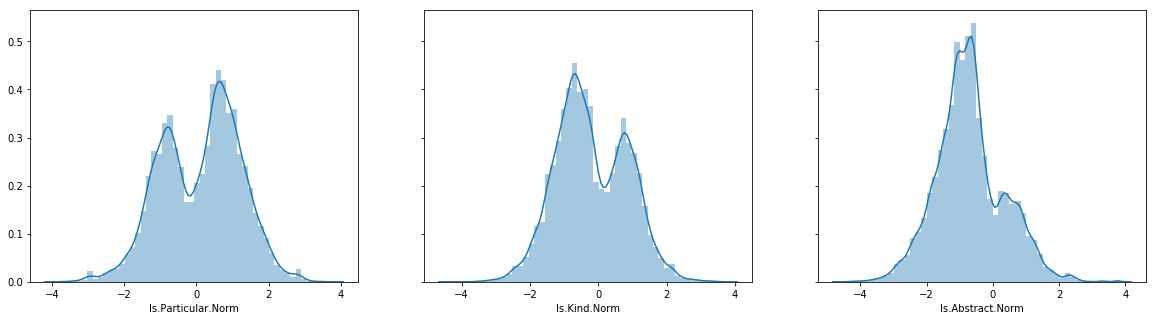

In [35]:
display(pd.DataFrame(create_corr_df(arg_data_unq, attributes_arg)))
display(pd.DataFrame(create_dist(arg_data_unq, attributes_arg)))

fig, ax = plt.subplots(figsize=[20, 5], nrows=1, ncols=3, squeeze=False, sharey='row')
for i in range(3):
    sns.distplot(arg_data_unq[attributes_arg[i]], ax=ax[0][i]).get_figure()
plt.show()


## Argument predictions

,Is.Particular.Pred,Is.Kind.Pred,Is.Abstract.Pred
Is.Abstract.Pred,-0.621,-0.098,1.000
Is.Kind.Pred,-0.654,1.000,-0.098
Is.Particular.Pred,1.000,-0.654,-0.621


,Is.Particular.Pred,Is.Kind.Pred,Is.Abstract.Pred
mean,0.156,-0.170,-0.701
median,0.279,-0.296,-0.851
var,0.366,0.246,0.212


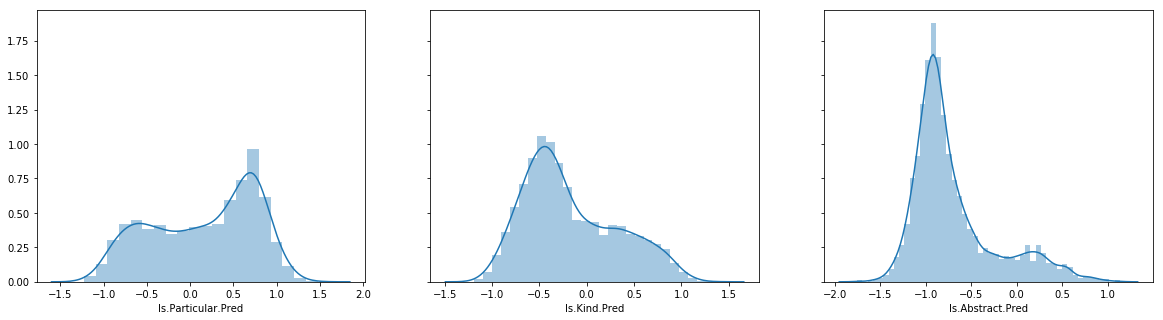

In [36]:
display(pd.DataFrame(create_corr_df(arg_dev, attributes_arg_dev)))
display(pd.DataFrame(create_dist(arg_dev, attributes_arg_dev)))

fig, ax = plt.subplots(figsize=[20, 5], nrows=1, ncols=3, squeeze=False, sharey='row')
for i in range(3):
    sns.distplot(arg_dev[attributes_arg_dev[i]], ax=ax[0][i]).get_figure()
plt.show()

## Predicate annotations

,Is.Particular.Norm,Is.Hypothetical.Norm,Is.Dynamic.Norm
Is.Dynamic.Norm,0.001,-0.069,1.000
Is.Hypothetical.Norm,-0.253,1.000,-0.069
Is.Particular.Norm,1.000,-0.253,0.001


,Is.Particular.Norm,Is.Hypothetical.Norm,Is.Dynamic.Norm
mean,0.407,-0.246,0.145
median,0.516,-0.422,0.237
var,1.113,1.213,1.028


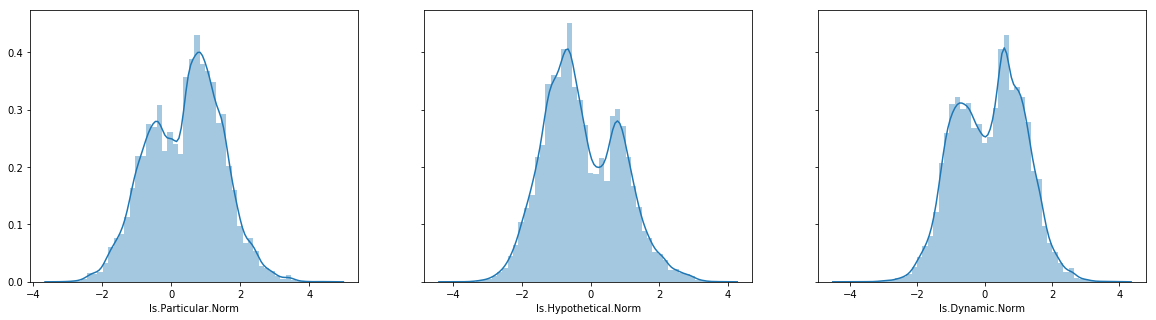

In [37]:
display(pd.DataFrame(create_corr_df(pred_data_unq, attributes_pred)))
display(pd.DataFrame(create_dist(pred_data_unq, attributes_pred)))

fig, ax = plt.subplots(figsize=[20, 5], nrows=1, ncols=3, squeeze=False, sharey='row')
for i in range(3):
    sns.distplot(pred_data_unq[attributes_pred[i]], ax=ax[0][i]).get_figure()
plt.show()

## Predicate predictions

,Is.Particular.Pred,Is.Hypothetical.Pred,Is.Dynamic.Pred
Is.Dynamic.Pred,0.341,0.031,1.000
Is.Hypothetical.Pred,-0.787,1.000,0.031
Is.Particular.Pred,1.000,-0.787,0.341


,Is.Particular.Pred,Is.Hypothetical.Pred,Is.Dynamic.Pred
mean,0.435,-0.313,0.134
median,0.421,-0.355,0.228
var,0.082,0.179,0.163


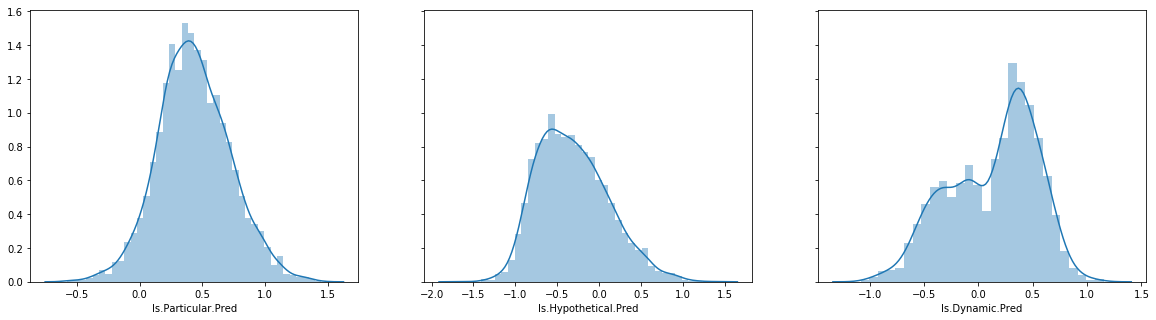

In [38]:
display(pd.DataFrame(create_corr_df(pred_dev, attributes_pred_dev)))
display(pd.DataFrame(create_dist(pred_dev, attributes_pred_dev)))

fig, ax = plt.subplots(figsize=[20, 5], nrows=1, ncols=3, squeeze=False, sharey='row')
for i in range(3):
    sns.distplot(pred_dev[attributes_pred_dev[i]], ax=ax[0][i]).get_figure()
plt.show()

In [ ]:
display(arg_dev[(arg_dev['Is.Particular.Norm']<-0.2) & (arg_dev['Is.Abstract.Norm']<-0.2)][['Unique.ID', 'Sentences', 'Word', 'Is.Particular.Norm', 'Is.Particular.Pred', 'Is.Abstract.Norm', 'Is.Abstract.Pred', 'Is.Kind.Norm', 'Is.Kind.Pred']].sort_values(by=['Is.Particular.Pred', 'Is.Abstract.Pred'], ascending=False))

## Proper nouns

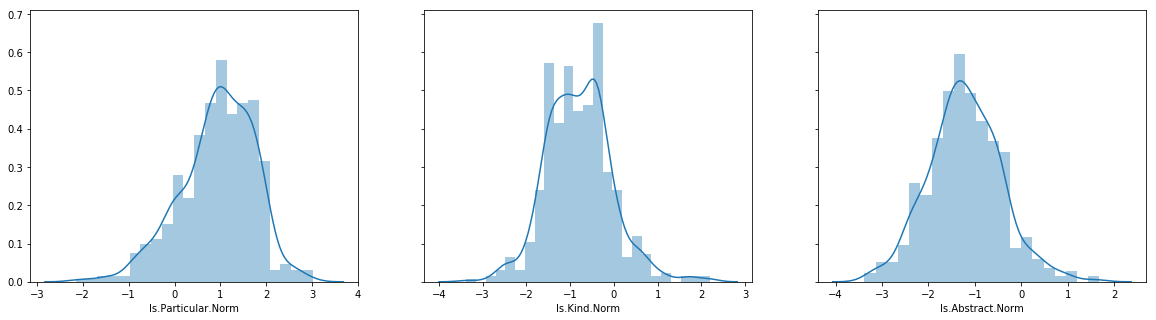

,Unique.ID,Sentences,Arg.Word,Is.Particular.Norm,Is.Particular.Pred,Is.Kind.Norm,Is.Kind.Pred,Is.Abstract.Norm,Is.Abstract.Pred
599,en-ud-dev.conllu sent_1280_2,"Try Varkala , it s a ammazing and is by the beach .",Varkala,0.653031,1.470786,-0.404319,-1.186215,-1.134729,-1.403005
1279,en-ud-dev.conllu sent_1665_12,Fish tacos are my fave simple and filling Highly recommend Mi Pueblo .,Pueblo,1.198812,1.375896,-0.422654,-1.148132,-0.345004,-1.411865
2294,en-ud-dev.conllu sent_35_2,"In Ramadi , there was a big demonstration .",Ramadi,1.802925,1.351713,-1.482712,-1.108724,-0.985668,-1.328597
924,en-ud-dev.conllu sent_13_2,"In Fallujah , hundreds of demonstrators came out against US troops when they briefly arrested a yound newlywed bride .",Fallujah,1.495761,1.339531,-0.678913,-1.137707,0.081598,-1.347908
263,en-ud-dev.conllu sent_1122_14,My boyfriend 's birthday is November 22nd and we are going to Del Frisco 's for dinner .,Frisco,1.097699,1.302510,-0.472682,-1.037311,-1.007838,-1.361670
783,en-ud-dev.conllu sent_1349_18,"Buses , DTC Buses , Call Center Cabs , Private white line buses most frequently running between Noida and Greater Noida .",Noida,1.580065,1.284226,-1.331595,-0.982258,-0.649966,-1.238605
285,en-ud-dev.conllu sent_1132_7,I will be going to Del Frisco 's in late November for dinner and I was wondering what the dress code is for a female .,Frisco,-0.039959,1.277845,-0.369010,-1.029881,-0.418781,-1.344754
3584,en-ud-dev.conllu sent_992_43,Normally this author is semi-objective &lcrb; what blogger is &rcrb; but on the Seattlepi.com &lcrb; see source link &rcrb; Palestinian Leader Mahmoud Abbas has demanded that Israel leave all the land that it occupies before the 1967 border &lcrb; which includes East Jerusalem by the way &rcrb; .,Jerusalem,0.808918,1.257794,-2.457174,-1.101121,-1.051451,-1.181442
167,en-ud-dev.conllu sent_1070_11,How many days will speed post take to reach from Delhi to Mumbai ?,Delhi,1.316853,1.250497,-0.814959,-1.000084,-1.284715,-1.225269
686,en-ud-dev.conllu sent_1314_11,Yes storage for your luggages is still available at Gare Montparnasse .,Montparnasse,0.978501,1.238946,-0.668198,-1.008494,-1.558686,-1.266823


In [45]:
upper = arg_dev[(arg_dev['POS']=='PROPN')]

fig, ax = plt.subplots(figsize=[20, 5], nrows=1, ncols=3, squeeze=False, sharey='row')
for i in range(3):
    sns.distplot(upper[attributes_arg[i]], ax=ax[0][i]).get_figure()
plt.show()

display(arg_dev[(arg_dev['POS']=='PROPN')][['Unique.ID', 'Sentences', 'Arg.Word', 'Is.Particular.Norm', 'Is.Particular.Pred', 'Is.Kind.Norm', 'Is.Kind.Pred', 'Is.Abstract.Norm', 'Is.Abstract.Pred']].sort_values(by=['Is.Particular.Pred', 'Is.Kind.Pred'], ascending=False))

In [54]:
display(arg_dev[(arg_dev['POS']=='NOUN') & (arg_dev['Is.Particular.Norm']<-0.2) & (arg_dev['Is.Abstract.Norm']<-0.2) & (arg_dev['Is.Particular.Pred']<-0.2) & (arg_dev['Is.Abstract.Pred']<-0.2) & ((arg_dev['Is.Kind.Pred'] - arg_dev['Is.Kind.Norm'])>0)][['Unique.ID', 'Sentences', 'Arg.Word', 'Is.Particular.Norm', 'Is.Particular.Pred', 'Is.Kind.Norm', 'Is.Kind.Pred', 'Is.Abstract.Norm', 'Is.Abstract.Pred']].sort_values(by=['Is.Particular.Pred', 'Is.Kind.Pred'], ascending=False))

,Unique.ID,Sentences,Arg.Word,Is.Particular.Norm,Is.Particular.Pred,Is.Kind.Norm,Is.Kind.Pred,Is.Abstract.Norm,Is.Abstract.Pred
1031,en-ud-dev.conllu sent_1443_6,Is it ok for a woman in french culture to make the first move ?,woman,-0.337258,-0.221228,0.419039,0.653110,-1.569992,-1.022298
1058,en-ud-dev.conllu sent_147_5,This is not a filibuster .,filibuster,-1.601943,-0.236434,-0.381838,0.358948,-0.922648,-0.573508
617,en-ud-dev.conllu sent_1287_7,You can try picking up the eggs and holding it up against a very bright light .,eggs,-0.677137,-0.240515,-0.628755,0.665553,-2.019739,-1.054167
579,en-ud-dev.conllu sent_1275_43,I do n't think they ban if the tats are n't offensive and you should make them not noticeable at the time of the interview but once you got the job there nothing they can really say if so you have a sue / case against them,sue,-1.760409,-0.246803,-0.255360,0.174852,-0.286511,-0.584223
3514,en-ud-dev.conllu sent_972_10,Exxon Mobil released nonessential staff from two giant Texas plants .,plants,-1.154976,-0.253516,0.530277,0.714924,-0.929312,-1.002857
2422,en-ud-dev.conllu sent_440_15,PLEASE NOTE : Your pledge is to be made electronically - it only takes minutes .,minutes,-0.366755,-0.257428,-0.608238,0.055015,-0.459048,-0.478494
3172,en-ud-dev.conllu sent_861_19,"While there have been spasms of speculation about the Bush administration naming a replacement for O'Keefe , no nominee has been declared .",nominee,-0.476417,-0.265669,0.087898,0.442810,-1.052824,-0.818855
2663,en-ud-dev.conllu sent_54_7,Now Iran wants to turn the tables and is inviting cartoonists to do their best by depicting the Holocaust .,tables,-2.580459,-0.280628,-1.525209,0.462590,-0.833180,-0.823540
3247,en-ud-dev.conllu sent_897_26,I was ashamed to be in friendship with girls ... until I undrstood that it 's not seakness as well as women wearing men 's pants is n't seak :&rcrb;,pants,-0.569198,-0.283177,0.374337,0.574776,-0.636839,-0.856498
753,en-ud-dev.conllu sent_1334_20,"I searched all over the internet , but I could not find one place in Tampa Bay that sells morcillas , also known as blood pudding , black pudding and blood sausages .",morcillas,-0.492243,-0.304646,0.351979,0.542589,-0.927665,-0.847684


### Particular and dynamic predicates

In [44]:
display(pred_dev[(pred_dev['Is.Particular.Pred']>0.1) & (pred_dev['Is.Dynamic.Pred']>0.1) & (pred_dev['Is.Dynamic.Norm']<-0.1)][['Unique.ID', 'Sentences', 'Pred.Word', 'Is.Particular.Norm', 'Is.Particular.Pred', 'Is.Hypothetical.Norm', 'Is.Hypothetical.Pred', 'Is.Dynamic.Norm', 'Is.Dynamic.Pred']].sort_values(by=['Is.Particular.Pred', 'Is.Dynamic.Pred'], ascending=False))

,Unique.ID,Sentences,Pred.Word,Is.Particular.Norm,Is.Particular.Pred,Is.Hypothetical.Norm,Is.Hypothetical.Pred,Is.Dynamic.Norm,Is.Dynamic.Pred
2098,"en-ud-dev.conllu sent_33_10,11,13",Ash - Sharq al - Awsat reports that Fallujah was closed Tuesday in a general strike .,closed,1.235729,1.322316,-1.174650,-1.126483,-0.438664,0.645294
320,"en-ud-dev.conllu sent_118_11,12",""" We were on the road and the first bridge was bombed and we drove home and all the other bridges were bombed and there was absolutely no way for us to get home , "" Chahine told reporters outside federal court in Detroit .",bombed,1.965653,1.298625,-1.299897,-0.997652,-0.355442,0.734384
321,"en-ud-dev.conllu sent_118_15,16",""" We were on the road and the first bridge was bombed and we drove home and all the other bridges were bombed and there was absolutely no way for us to get home , "" Chahine told reporters outside federal court in Detroit .",drove,1.459459,1.279341,-1.983711,-0.921048,-0.197398,0.946163
322,"en-ud-dev.conllu sent_118_22,23",""" We were on the road and the first bridge was bombed and we drove home and all the other bridges were bombed and there was absolutely no way for us to get home , "" Chahine told reporters outside federal court in Detroit .",bombed,1.582158,1.205729,-1.281722,-0.887655,-0.195971,0.730806
1743,"en-ud-dev.conllu sent_1986_14,17",Neither me nor my son have n't had a single cavity since we started dental care there .,started,1.029027,1.167600,-0.049495,-0.791862,-0.611090,0.605068
880,en-ud-dev.conllu sent_141_12,"He was the person , he and his wife Jan , introduced -- reintroduced me and Laura in his backyard in July of 1977 .",introduced,1.261355,1.158410,-0.810860,-1.118809,-0.193270,0.574495
2102,"en-ud-dev.conllu sent_345_4,5",Bruce indicated NiMo short listed five companies who all bid higher than ENA .,listed,0.432267,1.153487,-1.294062,-0.970969,-0.247944,0.351704
763,en-ud-dev.conllu sent_1380_10,My cat s Called Frank because the year we got him was the year Frank Sinatra died,got,0.373817,1.133727,-0.082084,-0.956044,-0.287672,0.458412
855,"en-ud-dev.conllu sent_1409_5,6,7",The one time I actually booked through a travel agent I did not get all of the amenities I had paid for .,booked,1.577163,1.119086,-1.664082,-0.671910,-0.702896,0.616284
3128,"en-ud-dev.conllu sent_950_2,7,11","But within a few short months , the village people began to notice their wells were running dry , so they complained to the corporation .",began,0.031181,1.100729,-1.963760,-0.972627,-0.266496,0.434786


### Particular and hypothetical predicates

In [42]:
display(pred_dev[(pred_dev['Is.Particular.Norm']>0.3) & (pred_dev['Is.Hypothetical.Norm']>0.3) & (pred_dev['Is.Particular.Pred']>0) & (pred_dev['Is.Hypothetical.Pred']<0)][['Unique.ID', 'Sentences', 'Pred.Word', 'Is.Particular.Norm', 'Is.Particular.Pred', 'Is.Hypothetical.Norm', 'Is.Hypothetical.Pred', 'Is.Dynamic.Norm', 'Is.Dynamic.Pred']].sort_values(by=['Is.Particular.Norm', 'Is.Hypothetical.Norm'], ascending=False))

,Unique.ID,Sentences,Pred.Word,Is.Particular.Norm,Is.Particular.Pred,Is.Hypothetical.Norm,Is.Hypothetical.Pred,Is.Dynamic.Norm,Is.Dynamic.Pred
3083,"en-ud-dev.conllu sent_927_20,23,24","i am deadly serious , i really do get sexual releif from even hearing of torture of animals , now some people may call me a brute or a coward but i ca nt help my true feelings .",call,3.032630,0.379778,0.997410,-0.072783,0.333867,0.506048
2945,"en-ud-dev.conllu sent_85_30,31",For the last few years there have been tensions with Iran 's nuclear program with word coming this week that a deal was reached through the European Union that meets with the approval of the International Atomic Energy Agency .,meets,2.794996,0.545840,0.455268,-0.426184,-1.064544,0.198023
812,en-ud-dev.conllu sent_1394_16,I have a day stop - over in San Francisco and my wife want to see some of the key sites .,see,2.750814,0.390861,0.650315,-0.239012,1.312767,0.309643
3230,en-ud-dev.conllu sent_986_3,""" I hope that industry , if put to the test , can do better [ than the government ] , but I do not expect it , "" Griffin added .",hope,2.623605,0.117560,2.284676,-0.044478,0.282281,0.046492
1872,"en-ud-dev.conllu sent_221_12,13,14,15,16,17","So I may as well just come out with it : It is pretty suspicious , given the Neocon predominance in the CPA and in the upper reaches of the Defense Department that on April 2 AP reported of Muqtada :","is pretty suspicious , given",2.469555,0.499246,0.400401,-0.452345,-0.708971,-0.221921
2736,"en-ud-dev.conllu sent_743_6,7",Let me know what you think of this property .,think,2.250997,0.179951,0.522504,-0.042610,0.614159,0.250342
2720,"en-ud-dev.conllu sent_731_15,16","If the negotiations stall , it seems like I need to go ahead and cut off the utilities .",cut,2.152259,0.570289,0.595976,-0.509304,0.574764,0.665056
1156,"en-ud-dev.conllu sent_1646_13,14,15,16","Not only are these people completely inefficient and ineffective , but they just do n't give a darn .",give,2.119084,0.416144,1.663945,-0.400151,-0.261976,0.405204
2457,en-ud-dev.conllu sent_54_17,Now Iran wants to turn the tables and is inviting cartoonists to do their best by depicting the Holocaust .,depicting,2.036846,0.491673,0.910314,-0.301079,0.464036,0.583292
3172,en-ud-dev.conllu sent_963_20,"Crude - oil prices rose Wednesday as strengthening Hurricane Rita , now a Category 5 storm , threatened to disrupt oil production in the Gulf of Mexico .",disrupt,2.028086,0.364111,0.961297,-0.030727,1.441802,0.292798


## Clausal versus other DEPREL

In [ ]:
clause_deprel = ['csubj', 'ccomp', 'xcomp', 'advcl', 'acl']
other_deprel = ['root', 'conj', 'parataxis']

pprint([(a, len(pred_dev[pred_dev['DEPREL'].isin(a)])) for a in [clause_deprel, other_deprel]])

for deprel_set in [clause_deprel, other_deprel]:
    data_new = pred_dev[pred_dev['DEPREL'].isin(deprel_set)]
    print('&', np.round(pearsonr(data_new['Is.Particular.Norm'], data_new['Is.Particular.Pred'])[0] * 100, sigdig), 
          '&', np.round(r1_score(data_new['Is.Particular.Norm'], data_new['Is.Particular.Pred']) * 100, sigdig), 
          '&', np.round(pearsonr(data_new['Is.Hypothetical.Norm'], data_new['Is.Hypothetical.Pred'])[0] * 100, sigdig), 
          '&', np.round(r1_score(data_new['Is.Hypothetical.Norm'], data_new['Is.Hypothetical.Pred']) * 100, sigdig),
          '&', np.round(pearsonr(data_new['Is.Dynamic.Norm'], data_new['Is.Dynamic.Pred'])[0] * 100, sigdig),
          '&', np.round(r1_score(data_new['Is.Dynamic.Norm'], data_new['Is.Dynamic.Pred']) * 100, sigdig), 
          '&', np.round(r1_score(data_new.loc[:, ['Is.Particular.Norm', 'Is.Hypothetical.Norm', 'Is.Dynamic.Norm']].values, data_new.loc[:, ['Is.Particular.Pred', 'Is.Hypothetical.Pred', 'Is.Dynamic.Pred']].values) * 100, sigdig), "\\\\")
print(np.round(pearsonr(pred_dev['Is.Particular.Norm'], pred_dev['Is.Particular.Pred'])[0] * 100, sigdig), '&', np.round(r1_score(pred_dev['Is.Particular.Norm'], pred_dev['Is.Particular.Pred']) * 100, sigdig))

In [53]:
display(arg_dev[(arg_dev['POS']=='NOUN') & (arg_dev['Is.Particular.Norm']<-0.2) & (arg_dev['Is.Kind.Norm']<-0.2) & (arg_dev['Is.Abstract.Norm']>0.2)][['Unique.ID', 'Sentences', 'Arg.Word', 'Is.Particular.Norm', 'Is.Kind.Norm', 'Is.Abstract.Norm']].sort_values(by=['Is.Particular.Norm', 'Is.Kind.Norm'], ascending=False))

,Unique.ID,Sentences,Arg.Word,Is.Particular.Norm,Is.Kind.Norm,Is.Abstract.Norm
2481,en-ud-dev.conllu sent_47_1,"Simplicity gave it that blessed , laudatory lack of clutter , the efficient and effective text - based ads , and the support of anyone with a dial - up connection .",Simplicity,-0.209873,-1.039112,0.822129
2022,en-ud-dev.conllu sent_223_9,""" I have said and I repeat my expression of solidarity which Hassan Nasrallah called for to stand with Hamas , "" Shiite cleric Muqtada al - Sadr said Friday in a reference to Nasrallah , the leader of the militant Lebanese Shiite group Hezbollah .",expression,-0.225014,-0.360591,1.668996
2910,en-ud-dev.conllu sent_717_8,Thank you for digging in to the issue of Deferred Phantom Stock Units .,issue,-0.233337,-0.399221,0.353881
1756,en-ud-dev.conllu sent_1938_9,Thought adding a comment would save someone the hassle with a useless trip there .,hassle,-0.239886,-0.947094,0.414814
1858,en-ud-dev.conllu sent_1987_3,The team focus is prevention and education .,focus,-0.240929,-0.760205,0.289517
1032,en-ud-dev.conllu sent_1443_9,Is it ok for a woman in french culture to make the first move ?,culture,-0.253817,-0.274711,1.326307
3007,en-ud-dev.conllu sent_778_12,"Come visit irc server : irc.yankeedot.net and join # audiobooks for sharing , discussion and a great trivia game ! large selection of fiction , science fiction and best sellers .",sharing,-0.255305,-0.950615,0.297250
2819,en-ud-dev.conllu sent_664_6,"When we start the summer process , we will interview the candidate and slot him for your group .",process,-0.262288,-0.461983,0.223298
1879,en-ud-dev.conllu sent_1995_18,There is something wrong or maybe the individual made a mistake but to me that is not integrity .,integrity,-0.268915,-1.492681,1.983400
85,en-ud-dev.conllu sent_1025_9,"Israel wants to drive the Palestinians toward civil war . """,war,-0.269484,-0.261510,0.766431


In [58]:
display(arg_dev[arg_dev['Arg.Lemma'].isin(['people'])][['Is.Kind.Norm', 'Is.Kind.Pred']])

,Is.Kind.Norm,Is.Kind.Pred
2,0.337922,0.365494
191,1.613984,0.840619
271,0.666797,0.878737
407,1.651218,0.730583
508,0.279343,0.743819
527,-0.222546,0.848500
531,1.578048,0.937733
601,-0.126688,0.697843
1206,0.112261,0.898761
1248,0.511155,0.697080


In [65]:
sent_len = arg_dev.copy()
sent_len['len'] = sent_len['Sentences'].apply(lambda x: len(x.split()))
for prop in ['Is.Particular', 'Is.Kind', 'Is.Abstract']:
    sent_len[prop + '.Error'] = sent_len[prop + '.Norm'] - sent_len[prop + '.Pred']
    print(pearsonr(sent_len[prop + '.Error'], sent_len['len'])[0])

0.0003097265468639905
-0.02468454427123564
0.03236782940744645


In [66]:
sent_len_pred = pred_dev.copy()
sent_len_pred['len'] = sent_len_pred['Sentences'].apply(lambda x: len(x.split()))
for prop in ['Is.Particular', 'Is.Hypothetical', 'Is.Dynamic']:
    sent_len_pred[prop + '.Error'] = sent_len_pred[prop + '.Norm'] - sent_len_pred[prop + '.Pred']
    print(pearsonr(sent_len_pred[prop + '.Error'], sent_len_pred['len'])[0])

0.022687479466382863
0.0328725223779224
-0.009001827715819012


In [67]:
sent_len.sample(5)

,Unique.ID,Sentences,Arg.Word,Arg.Lemma,POS,DEPREL,Is.Particular.Norm,Is.Particular.Pred,Is.Kind.Norm,Is.Kind.Pred,Is.Abstract.Norm,Is.Abstract.Pred,len,Is.Particular.Error,Is.Kind.Error,Is.Abstract.Error
558,en-ud-dev.conllu sent_1270_6,"Maybe if you post the question again , someone will give you a good answer .",question,question,NOUN,dobj,0.727620,0.671136,-0.512861,-0.405813,-1.256247,-0.938605,16,0.056484,-0.107048,-0.317642
2518,en-ud-dev.conllu sent_503_2,Thank you .,you,you,PRON,dobj,0.987068,0.793610,-0.341531,-0.732771,-2.759884,-0.842452,3,0.193457,0.391240,-1.917432
3426,en-ud-dev.conllu sent_953_3,"The village soil and water are now too heavily contaminated to safely occupy human life , so the plant was shut down last week .",soil,soil,NOUN,nsubjpass,1.438001,0.221569,-0.332117,0.147422,-1.359941,-0.869104,25,1.216432,-0.479539,-0.490837
906,en-ud-dev.conllu sent_1396_20,"We have limited time What are the best sights to see , geiven that we only have a short time ?",time,time,NOUN,dobj,-0.550657,-0.725342,-0.876249,-0.345543,1.539795,0.244051,21,0.174684,-0.530706,1.295744
420,en-ud-dev.conllu sent_1210_1,Anyone who looks like a druggy or dodgy .,Anyone,anyone,NOUN,root,-0.883104,-0.972481,1.183919,0.689316,-2.309494,-0.906551,9,0.089377,0.494603,-1.402943
